In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
sns.color_palette(["#4a4a4a", "#00798c", "#d1495b", '#edae49', '#66a182', '#ffe2b3', '#ccffe4'])

[(0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (1.0, 0.8862745098039215, 0.7019607843137254),
 (0.8, 1.0, 0.8941176470588236)]

# 1. Figure 3B. Comparison of Changes in Property Score

In [190]:
psres = pd.read_csv('../Results/Results2/2.PSMdata.csv', index_col=0)
psres.head(2)
plotdata = []
for i in psres.index:
    plotdata.append([psres.loc[i, 'Project'], 'Unmatched', psres.loc[i, 'Delta_Unmatched']])
    plotdata.append([psres.loc[i, 'Project'], 'Matched', psres.loc[i, 'Delta_Matched']])
plotdata = pd.DataFrame(plotdata, columns=['Project', 'isMatched', 'Propensity score (Case - Control)'])
plotdata.head(2)

,Project,Control,Case,Control_matched,Case_matched,Delta_Unmatched,Delta_Matched
0,08,0.938393,0.988357,0.983176,0.983748,0.049964,0.000572
1,09,0.373933,0.626067,0.627506,0.631632,0.252133,0.004126


,Project,isMatched,Propensity score (Case - Control)
0,08,Unmatched,0.049964
1,08,Matched,0.000572


(0.11490745834857191, 0.4804949378551523, 0.000663027376469383)

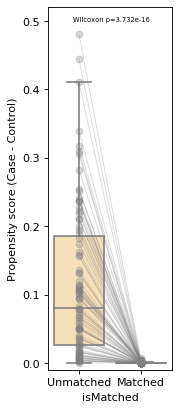

In [191]:
_ = plt.figure(0, (2, 6), dpi=80)
_ = sns.boxplot(data=plotdata, x="isMatched", y="Propensity score (Case - Control)", order=["Unmatched", "Matched"], palette=['#ffe2b3', '#ccffe4'], 
                fliersize=0)
for i in psres.index:
    _ = plt.plot([0, 1], psres.loc[i, ['Delta_Unmatched', 'Delta_Matched']], '-o', alpha=0.3, color='gray', lw=0.8)

psres['Delta_Unmatched'].mean(), psres['Delta_Unmatched'].max(), psres['Delta_Matched'].mean()

p = stats.wilcoxon(psres['Delta_Unmatched'], psres['Delta_Matched'], alternative='two-sided')[1]
_ = plt.annotate('Wilcoxon p=%.3e'%p, (-0.1, 0.5), fontsize=6)
_ = plt.ylim([-0.01, 0.52])
_ = plt.savefig('../20230718_Results/Figure 3B. PS Change.pdf', dpi=300)
_ = plt.show()

In [9]:
psres.sort_values(['Delta_Unmatched']).tail(2)

,Project,Control,Case,Control_matched,Case_matched,Delta_Unmatched,Delta_Matched
12,26,0.277921,0.722079,0.698820,0.700677,0.444157,0.001858
5,15,0.420025,0.900520,0.780704,0.784387,0.480495,0.003683


5: acute diarrhoea [DavidLA_2015]

26: CRC [GuptaA_2019]

# 2. Figure 3CD. The relationship between Property score and Host condenser

* Use LinearRegression for fitting (PS~Host foundations);
* Calculate R2 to evaluate the fitting effect;
* Permutation importance for feature evaluation (n=10)

In [75]:
data = pd.read_csv('../20230718_Results/Table S3. Propensity score与Host confounder的关系.tsv', sep='\t', index_col=0)

In [76]:
data.head(2)

,project,Site,Control,Case,Sample,Feature,R2,age_category_adult,age,gender_male,...,antibiotics_family_carbapenems;fluoroquinolones;laxatives,antibiotics_family_carbapenems;fluoroquinolones,tnm_t3n2m1,tnm_t1n0m1,tnm_tisn0m0,disease_location_rc,ALT,tnm_t3n3m1,disease_location_lc,eGFR
0,08,stool,control,premature_born,408,9,0.046414,NaN,0.000000,0.00178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,09,oralcavity,control,schizofrenia,32,5,0.196620,0.0,0.000652,0.01021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R2   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.452
Date:                Tue, 25 Jul 2023   Prob (F-statistic):            0.00768
Time:                        07:03:03   Log-Likelihood:                 54.594
No. Observations:                  88   AIC:                            -105.2
Df Residuals:                      86   BIC:                            -100.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0743      0.031      2.428      0.017       0.013       0.135
Feature        0.0086      0.003      2.730      0.008       0.002       0.015
==============================================================================
Omnibus:                       25.829   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.894
Skew:                           1.342   Prob(JB):                     9.74e-09
Kurtosis:                       4.692   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

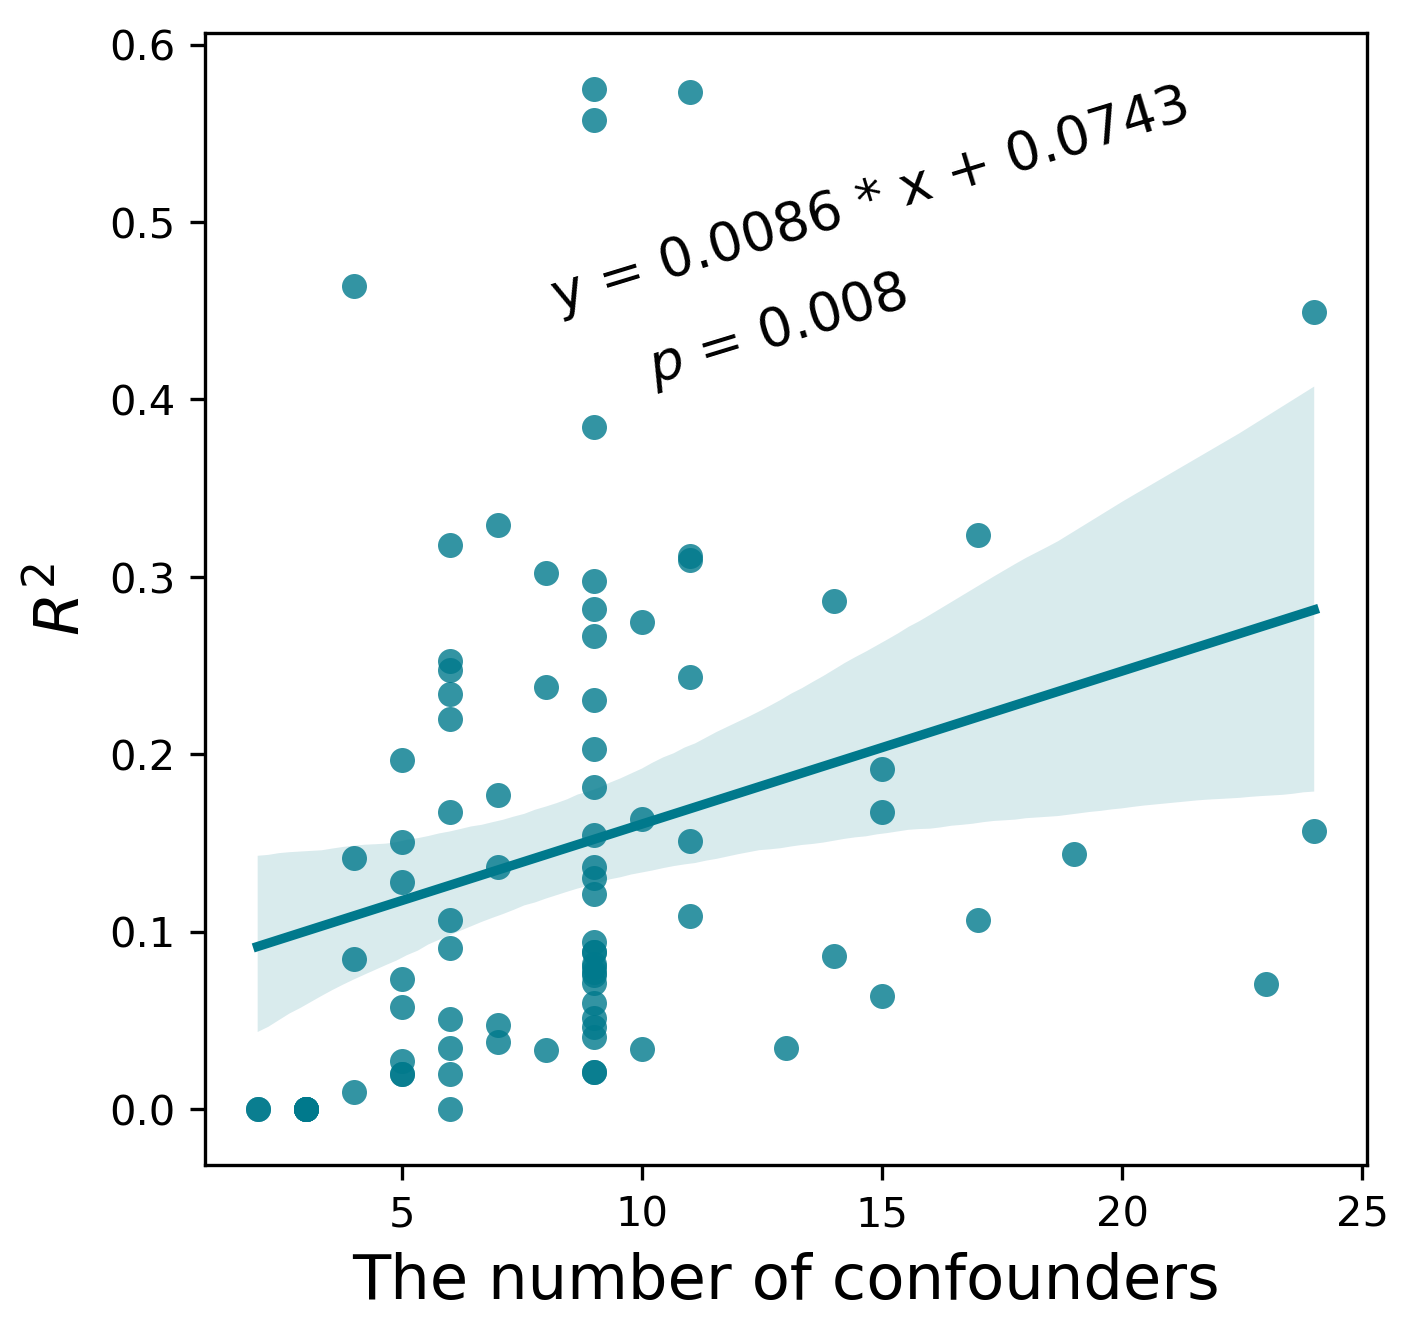

In [92]:
fig = plt.figure(0, (5, 5), dpi=300)
p = sns.regplot(x="Feature", y="R2", data=result, color='#00798c', scatter_kws={'linewidths':0})

slope, intercept, r_value, p_value, std_err = stats.linregress(x=p.get_lines()[0].get_xdata(), y=p.get_lines()[0].get_ydata())
X = result['Feature']
X = sm.add_constant(X)
y = result['R2']
est=sm.OLS(y, X)
est=est.fit()
est.summary()

_ = plt.annotate('y = '+str(round(slope, 4))+' * x + '+str(round(abs(intercept), 4)), (8, 0.45), fontsize=13, rotation=17)
_ = plt.annotate('$p$ = 0.008', (10, 0.41), fontsize=13, rotation=17)

_ = plt.xlabel('The number of confounders', fontsize=15)
_ = plt.ylabel('$R^2$', fontsize=15)
_ = plt.savefig('../20230718_Results/Figure 3C. R2.pdf', dpi=300)
_ = plt.show()

In [199]:
features = np.array([('age', 'Age', '#f6bfbc'),('gender_male', 'Gender', '#f6bfbc'), ('BMI', 'BMI', '#f6bfbc'), 
                     
                     ('country_USA','Country_USA', '#bce2e8'), ('country_CHN','Country_CHN', '#bce2e8'), ('country_FIN','Country_FIN', '#bce2e8'),
                     ('country_EST','Country_EST', '#bce2e8'), ('country_RUS','Country_RUS', '#bce2e8'), ('country_DNK','Country_DNK', '#bce2e8'), 
                     ('country_ITA','Country_ITA', '#bce2e8'), ('country_JPN','Country_JPN', '#bce2e8'),
                     
                     
                     ('antibiotics_family_cephalosporins','Cephalosporins', '#f8e58c'), ('antibiotics_family_penicillins','Penicillins', '#f8e58c'), # 抗生素
                     ('treatment_metformin','Treatment_Metformin', '#f8e58c'), # 二甲双胍
                     
                     ('hla_drb11','HLA_DRB11', '#e0ebaf'),('hla_dqa11','HLA_DQA11', '#e0ebaf'), ('hla_drb12','HLA_DRB12', '#e0ebaf'),
                     ('hla_dqa12','HLA_DQA12', '#e0ebaf'), #HLA抗原
                     
                     ('smoker_yes','Smoke', '#f8b862'), # 吸烟
                     ('brinkman_index','Brinkman', '#f8b862'), # 吸烟量指数 Brinkman指数 = 每日吸烟量（支）×吸烟年数（年）
                     ('alcohol_numeric','Alcohol', '#f8b862'), # 酒精
                     
                     ('hdl', 'HDL', '#dbd0e6'), ('ldl', 'LDL', '#dbd0e6'), ('triglycerides','Triglycerides', '#dbd0e6'),
                     ('cholesterol', 'Cholesterol', '#dbd0e6'), # 脂质
                     ('fasting_glucose','Fasting Glucose', '#f8fbf8'), # 糖
                     ('creatinine','Creatinine', '#f8fbf8'), # 肌酸酐
                     ('fobt_yes','FOBT', '#f8fbf8'), #大便隐血试验
                     ('hba1c','HBA1C', '#f8fbf8'), #糖化血红蛋白
                     ('hscrp','HSCRP', '#f8fbf8'), # 超敏C反应蛋白 
                     ])

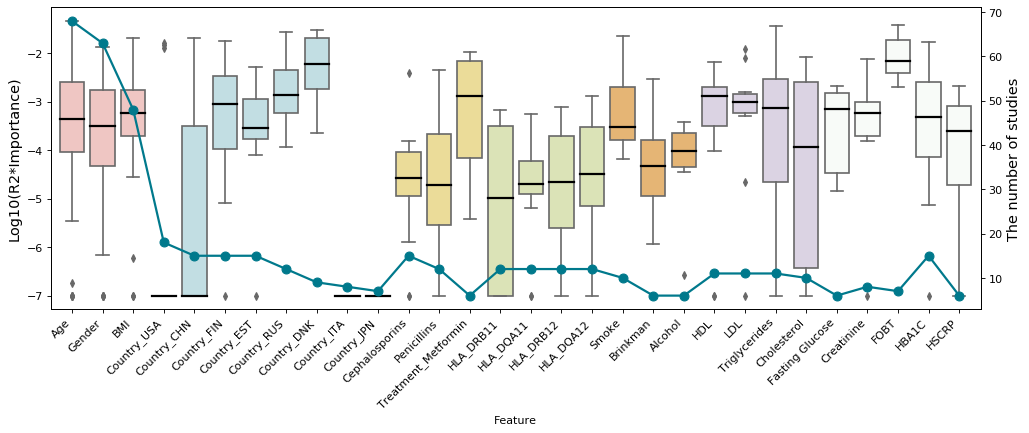

In [200]:
plotdata = data.loc[:, [i[0] for i in features]]
plotdata.columns = [i[1] for i in features]
count = (plotdata.shape[0]-plotdata.isnull().sum()).sort_values(ascending=False)
count = count[[i[1] for i in features]]

fig = plt.figure(0, (15, 5), dpi=80)
ax = fig.add_subplot(111)

plotdata = []
for f in count.index:
    for i in data.index:
        rf = dict(zip([i[1] for i in features], [i[0] for i in features]))[f]
        if str(data.loc[i, rf])!='nan':
            plotdata.append([i, f, np.log10(np.clip(data.loc[i, rf]*data.loc[i, 'R2'], 10**(-7), 1))])
plotdata = pd.DataFrame(plotdata, columns=['ID', 'Feature', 'Score'])
_ = sns.boxplot(data=plotdata, x="Feature", y="Score", order=count.index, palette=[i[2] for i in features], medianprops={'linewidth':2, "color":"k"}, ax=ax)
_ = plt.xticks(np.arange(count.shape[0]), count.index, rotation=45, ha='right')
_ = plt.ylabel('Log10(R2*Importance)', fontsize=13)
_ = plt.xlim([-0.7, count.shape[0]-0.3])

ax2 = ax.twinx()
_ = plt.plot(np.arange(count.shape[0]), count.values, '-', marker='o', zorder=999, lw=2, ms=8, color='#00798c')
#_ = plt.xticks(np.arange(count.shape[0]), count.index, rotation=45, ha='right')
_ = plt.ylabel('The number of studies', fontsize=13)
_ = plt.xlabel('Host confounders', fontsize=13)

_ = plt.savefig('../20230718_Results/Figure 3D. Importance.pdf', dpi=300)
_ = plt.show()